In [ ]:
pip install pydicom


In [ ]:
from google.colab import drive
drive.mount('/content/drive') #구글 드라이브 마운트

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

import tensorflow as tf
if (len(tf.config.list_physical_devices('GPU'))==1):
    print("TensorFlow has access to the GPU.")

In [ ]:
gpus=tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            print("GPU is available and configured sucesssfully")
    except RuntimeError as e:
        print(e)
else:
    print('No GPUS found!')

No GPUS found!


In [ ]:
with tf.device('/GPU:0'):
    a = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    b = tf.constant([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
    c = tf.matmul(a, b, transpose_b=True)  # Correct the matrix dimensions for matmul
    print(c.numpy())

[[14. 32.]
 [32. 77.]]


In [ ]:
#%cd /content/drive/MyDrive/멀티캠퍼스/data/final_data

In [ ]:
#!unzip -qq 'rsna-2024-lumbar-spine-degenerative-classification.zip' #알집풀기

In [ ]:
#경로 설정
start_dir_path="/content/drive/MyDrive/멀티캠퍼스"

#라이브러리 임폴트

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # 그래프를 그리고 작업하기 위한 라이브러리
import seaborn as sns
import cv2 # 이미지를 로드하고 읽기 위한 컴퓨터 비전 라이브러리
import pydicom # DICOM 이미지를 다루기 위한 라이브러리
import os # 운영 체제 라이브러리로, 컴퓨터 커널과 상호작용하고 터미널 명령을 실행하는 데 유용합니다
import glob # 파일 이름에서 글로벌 패턴을 찾는 데 도움이 되는 라이브러리
from tqdm import tqdm # 진행 상황 표시줄을 보여주는 라이브러리
import warnings # 필요한 경우 경고 메시지를 표시하는 라이브러리
import ipywidgets as widgets
from IPython.display import display
import logging
from multiprocessing import Pool

#train, test csv 경로
train_data_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/train.csv'
sample_csv_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/sample_submission.csv'
train_series_descriptions_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/train_series_descriptions.csv'
train_label_coordinates_data_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/train_label_coordinates.csv'
test_series_descriptions_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/test_series_descriptions.csv'

#이미지 폴더 경로
train_images_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/train_images'
test_images_path='/content/drive/MyDrive/멀티캠퍼스/data/final_data/test_images'


# csv파일 불러오기
sample_csv=pd.read_csv(sample_csv_path)
train_data=pd.read_csv(train_data_path)
train_series_description=pd.read_csv(train_series_descriptions_path)
test_series_description=pd.read_csv(test_series_descriptions_path)
train_label_coordinates_data=pd.read_csv(train_label_coordinates_data_path)

In [ ]:
#트레인 라벨 데이터에 카테고리열 추가하기
train_label_coordinates_data["category"] = None


for idx, row in train_label_coordinates_data.iterrows(): #각 행의 인덱스를 idx에 열값을 시리즈로 row에 담았음
    r = row['study_id']
    col = (row['condition'].lower().replace(' ', '_')) + '_' + (row['level'].lower().replace('/', '_')) #train.csv와 비교위해 condition열과 level열을 train열에 맞게 결합

  # train_data에서 KeyError를 피하기 위해 열이 존재하는지 확인합니다.
    if col in train_data.columns:
       #스터디 아이디에 해당하는 값이 있으면 value값을 카테고리열에 저장
        value = train_data.loc[train_data['study_id'] == r, col].values
        if len(value) > 0:
            train_label_coordinates_data.at[idx, "category"] = value[0]
        else:
            train_label_coordinates_data.at[idx, "category"] = None
    else:
        train_label_coordinates_data.at[idx, "category"] = None




In [ ]:


train_label_coordinates_data.head(1)

,study_id,series_id,instance_number,condition,level,x,y,category
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild


In [ ]:
# train_label_coordinates_data 데이터셋에서 이미지 파일 경로를 생성하는 과정

# train_label_coordinates_data 데이터셋에서 첫 세 열만 추출
first_three_cols = train_label_coordinates_data.iloc[:, :3]

# 각 행을 결합하여 이미지 파일 경로를 생성하는 함수 정의
join_row_as_str = lambda row: train_images_path + "/" + "/".join(row.astype(str)) + ".dcm"

# 각 행에 대해 함수를 적용하여 이미지 파일 경로를 생성
train_label_images_path = first_three_cols.apply(join_row_as_str, axis=1)

# 새로운 데이터프레임의 행 수와 원래 데이터프레임의 행 수가 같은지 확인
print(f'The number of rows in train_label_images_path and train_label_coordinates_data are equal? {train_label_images_path.shape[0]==train_label_coordinates_data.shape[0]}')

# 업데이트된 데이터셋의 형태를 출력
train_label_coordinates_data.shape

The number of rows in train_label_images_path and train_label_coordinates_data are equal? True


(48692, 8)

In [ ]:
# train_label_coordinates_data 데이터프레임에 img_file_path라는 새로운 열을 추가하고 초기값을 None으로 설정
train_label_coordinates_data["img_file_path"] = None

# train_label_coordinates_data의 각 행을 반복
for idx, row in train_label_coordinates_data.iterrows():
    # train_label_images_path에서 해당 인덱스의 파일 경로를 가져오기
    file_path = train_label_images_path.loc[idx]
    # 가져온 파일 경로를 train_label_coordinates_data의 img_file_path 열에 추가
    train_label_coordinates_data.at[idx, "img_file_path"] = file_path

In [ ]:


# 업데이트된 데이터프레임의 첫 행을 출력
print(train_label_coordinates_data.head(1).img_file_path)


0    /content/drive/MyDrive/멀티캠퍼스/data/final...
Name: img_file_path, dtype: object


In [ ]:
#/kaggle/usr/lib/rsna_functons/rsna_functons.py 파일에 정의된 모든 함수와 변수들 사용가능
%run '/content/drive/MyDrive/멀티캠퍼스/data/final_data/rsna_functons.py'

Function print_dir_str() sucesfully imported.
This function prints the files and folders in the root input folder.
---------

Function disaply_dicom_images(idx,df) sucessfully loaded.
This function to display a DICOM images for a given index (idx).
The function takes idx ,a integer which represents index of the image.
The second arg is df which is the dataset from wchich the image file path is derived.
The images are annoted by a transparent circle to marke the x and y coordinates marking the epicentre of the site being analysed

----------
Function create_image_slider(df) sucessfully imported.
This function creates a widget for scrolling through DICOM images

Functions preprocess_images(), load_and_deserialize_example(), and save_to_pickle() successfully loaded.

Function preprocess_images():
- Purpose: Resizes and normalizes images in a DataFrame, then serializes them using pickle.
- Arguments:
  - df (DataFrame): The dataset containing the paths to images.
  - image_column (str): Th

<Figure size 640x480 with 0 Axes>

In [ ]:

train_label_coordinates_data

,study_id,series_id,instance_number,condition,level,x,y,category,img_file_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
...,...,...,...,...,...,...,...,...,...
48687,4290709089,4237840455,11,Left Neural Foraminal Narrowing,L1/L2,219.465940,97.831063,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
48688,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L2/L3,205.340599,140.207084,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
48689,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L3/L4,202.724796,181.013624,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
48690,4290709089,4237840455,12,Left Neural Foraminal Narrowing,L4/L5,202.933333,219.733333,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...


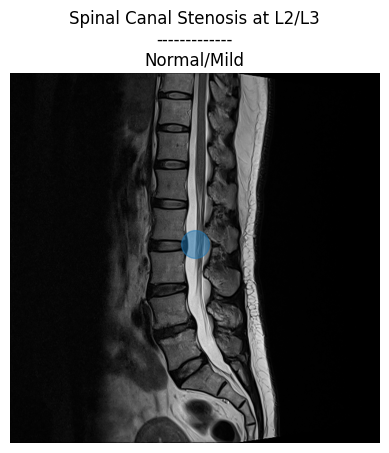

In [ ]:
display_dicom_images(1,train_label_coordinates_data)

In [ ]:
create_image_slider(train_label_coordinates_data)

interactive(children=(IntSlider(value=0, description='Image Index', max=48691), Output()), _dom_classes=('widg…

In [ ]:
# call the function print_dir_str()
print_dir_str(start_dir_path)

Total number of files and folder in root directory are = 23
---------------------------------------------------


[Root dir]

/content/drive/MyDrive/멀티캠퍼스

[Folders]

    /content/drive/MyDrive/멀티캠퍼스/data

[Files]

        /content/drive/MyDrive/멀티캠퍼스/Untitled1.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled5.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled2.ipynb
        /content/drive/MyDrive/멀티캠퍼스/python_day1.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled4.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled0.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled6.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled7.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled8.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled9.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled10.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Untitled11.ipynb
        /content/drive/MyDrive/멀티캠퍼스/Unt

['Untitled1.ipynb',
 'Untitled5.ipynb',
 'Untitled2.ipynb',
 'python_day1.ipynb',
 'Untitled4.ipynb',
 'Untitled0.ipynb',
 'Untitled6.ipynb',
 'Untitled7.ipynb',
 'Untitled8.ipynb',
 'Untitled9.ipynb',
 'Untitled10.ipynb',
 'Untitled11.ipynb',
 'Untitled3.ipynb',
 'data',
 'dl-day1.ipynb',
 'dl-day2.ipynb',
 'Untitled',
 'cnn-day1.ipynb',
 'rnn-day1.ipynb',
 'mentoring.ipynb',
 'dl-day3.ipynb',
 'kaggle_cnn.ipynb',
 'finalprj EDA.ipynb']

In [ ]:
train_label_coordinates_data.head()

,study_id,series_id,instance_number,condition,level,x,y,category,img_file_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...


In [ ]:
train_label_coordinates_data.shape

(48692, 9)

In [ ]:
train_data = train_label_coordinates_data

In [ ]:
# Check for missing values
display(train_data.isnull().sum())

study_id            0
series_id           0
instance_number     0
condition           0
level               0
x                   0
y                   0
category           35
img_file_path       0
dtype: int64

In [ ]:
# Display rows where the "category" column has missing values
missing_category_entries = train_data[train_data['category'].isnull()]

display(missing_category_entries.head(2))
print(f"Number of rows with missing 'category' entries: {len(missing_category_entries)}\n----\n")

# Get unique study IDs where 'category' is null
unique_study_ids_missing_category_entries = missing_category_entries['study_id'].unique()

# Count the number of unique study IDs
num_unique_study_ids_missing_category_entries = len(unique_study_ids_missing_category_entries)

# Print the number of unique study IDs with missing category entries
print(f"Number of unique study IDs with missing 'category' entries: {num_unique_study_ids_missing_category_entries}")
display(unique_study_ids_missing_category_entries)

,study_id,series_id,instance_number,condition,level,x,y,category,img_file_path
5364,462494704,682162323,9,Right Neural Foraminal Narrowing,L2/L3,260.974125,229.893455,NaN,/content/drive/MyDrive/멀티캠퍼스/data/final...
5365,462494704,682162323,9,Right Neural Foraminal Narrowing,L3/L4,244.608828,282.106545,NaN,/content/drive/MyDrive/멀티캠퍼스/data/final...


Number of rows with missing 'category' entries: 35
----

Number of unique study IDs with missing 'category' entries: 7


array([ 462494704,  482624307,  779042451, 1524089207, 2507107985,
       2607462358, 3781188430])

In [ ]:
# Drop rows with missing values without modifiying original df (hence inplace=False) and store this in new df names train:
train= train_data.dropna(inplace=False)

In [ ]:
#Confirm if there are still any missing valyes in new df:
num_of_missing_values=train.isnull().sum()
print(num_of_missing_values)

#Visualise the original and new df shapes and compare them :
print(f'\n----\nThe original dataframe (train_data) had {train_data.shape[0]} rows and {train_data.shape[1]} columns.')
print(f'The new dataframe (train) has {train.shape[0]} rows and {train.shape[1]} columns\n----\n')
print(f'We succesfulyl dropped {train_data.shape[0] - train.shape[0]} rows and {num_unique_study_ids_missing_category_entries} patients.')

study_id           0
series_id          0
instance_number    0
condition          0
level              0
x                  0
y                  0
category           0
img_file_path      0
dtype: int64

----
The original dataframe (train_data) had 48692 rows and 9 columns.
The new dataframe (train) has 48657 rows and 9 columns
----

We succesfulyl dropped 35 rows and 7 patients.


In [ ]:
train.head()

,study_id,series_id,instance_number,condition,level,x,y,category,img_file_path
0,4003253,702807833,8,Spinal Canal Stenosis,L1/L2,322.831858,227.964602,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
1,4003253,702807833,8,Spinal Canal Stenosis,L2/L3,320.571429,295.714286,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
2,4003253,702807833,8,Spinal Canal Stenosis,L3/L4,323.030303,371.818182,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
3,4003253,702807833,8,Spinal Canal Stenosis,L4/L5,335.292035,427.327434,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...
4,4003253,702807833,8,Spinal Canal Stenosis,L5/S1,353.415929,483.964602,Normal/Mild,/content/drive/MyDrive/멀티캠퍼스/data/final...


In [ ]:
processed_images=preprocess_images(train,"img_file_path",(224,224),-1) #시스템 메모리 부족으로 멈춰졌음..해결법 찾는중

 37%|███▋      | 18025/48657 [49:20<1:23:51,  6.09it/s]


KeyboardInterrupt: 

In [ ]:
processed_images